#### Основной источник кода: https://github.com/MrChrisJohnson/implicit-mf
#### Теория  - http://activisiongamescience.github.io/2016/01/11/Implicit-Recommender-Systems-Biased-Matrix-Factorization/

In [13]:
import numpy as np
import pandas as pd

from scipy import sparse

np.random.seed(0)

### Загружаем оценки и собираем из них матрицу оценок $r_{ij}$ 

In [2]:
df = pd.read_csv('a.txt', sep='\t')

In [3]:
df.head(2)

,12a1970 lexmark,2 stacker,21 black jack,2nd mortgage,acapulco hotel,accept account card credit merchant,accept card credit,accept card credit online,accessory computer,accessory desk,...,woman,work home,xenadrine,xenical,xenical on line,xxx,yohimbe,yukon,zinc,zyban
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Функция, которая делит множество оценок на test и train

In [5]:
# Делим данные на train и test 
# Для каждого пользователя 10 случайных "оценок" отправляем в test
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Проверяем, что   t est и train не пересекаются
    assert(np.all((train * test) == 0)) 
    return train, test

### Метрика качества

In [6]:
from sklearn.metrics import mean_squared_error

# лучше попробовать ранговую метрику Mean Avarage Precision@K, например
def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=3)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=3)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=25);
    plt.ylabel('MSE', fontsize=25);
    plt.legend(loc='best', fontsize=20);

# Implicit matrix factorization

In [18]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import time

class ImplicitMF():

    def __init__(self, ratings, num_factors=40, reg_param=0.8):
        self.counts = sparse.csr_matrix(ratings)
        self.ratings = ratings
        self.num_users = self.counts.shape[0]
        self.num_items = self.counts.shape[1]
        self.num_factors = num_factors
        self.reg_param = reg_param
        self.num_iterations=0
        
        self.user_vectors = np.random.normal(size=(self.num_users,
                                                   self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items,
                                                   self.num_factors))
        
    def train_model(self, num_iterations):
        
        for i in np.arange(num_iterations):
            t0 = time.time()
            # print ('Solving for user vectors...')
            self.user_vectors = self.iteration(True, sparse.csr_matrix(self.item_vectors))
            # print ('Solving for item vectors...')
            self.item_vectors = self.iteration(False, sparse.csr_matrix(self.user_vectors))
            t1 = time.time()
            #print ('iteration %i finished in %f seconds' % (i + 1, t1 - t0))

    def iteration(self, user, fixed_vecs):
        num_solve = self.num_users if user else self.num_items
        num_fixed = fixed_vecs.shape[0]
        YTY = fixed_vecs.T.dot(fixed_vecs)
        eye = sparse.eye(num_fixed)
        lambda_eye = self.reg_param * sparse.eye(self.num_factors)
        solve_vecs = np.zeros((num_solve, self.num_factors))

        for i in np.arange(num_solve):
            if user:
                counts_i = self.counts[i].toarray()
            else:
                counts_i = self.counts[:, i].T.toarray()
            CuI = sparse.diags(counts_i, [0])
            pu = counts_i.copy()
            pu[np.where(pu != 0)] = 1.0
            YTCuIY = fixed_vecs.T.dot(CuI).dot(fixed_vecs)
            YTCupu = fixed_vecs.T.dot(CuI + eye).dot(sparse.csr_matrix(pu).T)
            xu = spsolve(YTY + YTCuIY + lambda_eye, YTCupu)
            solve_vecs[i] = xu
            

        return solve_vecs
    
    def predict(self, u, i):
        """ Single user and item prediction."""
        return self.user_vectors[u, :].dot(self.item_vectors[i, :].T)
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vectors.shape[0], 
                                self.item_vectors.shape[0]))
        for u in range(self.user_vectors.shape[0]):
            for i in range(self.item_vectors.shape[0]):
                predictions[u, i] = self.predict(u, i)
        
        return predictions
    
    def calculate_learning_curve(self, iter_array, test):
        """
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            
            print (f'Iteration: {n_iter}')
            
            if i == 0:
                print(n_iter)
                self.train_model(n_iter)
            else:
                self.train_model(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            
            print (f'MSE train:test: {round(self.train_mse[-1],2)} : {round(self.test_mse[-1],2)}\n')
            iter_diff = n_iter

In [19]:
train, test = train_test_split(pd.DataFrame.as_matrix(df))

mf = ImplicitMF(ratings=train)

In [21]:
iter_array = [1, 2, 5, 10, 25, 50]
mf.calculate_learning_curve(iter_array, sparse.csr_matrix(test))

Iteration: 1
1
MSE train:test: 0.93 : 0.97

Iteration: 2
MSE train:test: 0.28 : 0.56

Iteration: 5
MSE train:test: 0.26 : 0.52

Iteration: 10
MSE train:test: 0.26 : 0.52

Iteration: 25
MSE train:test: 0.26 : 0.52

Iteration: 50
MSE train:test: 0.26 : 0.52



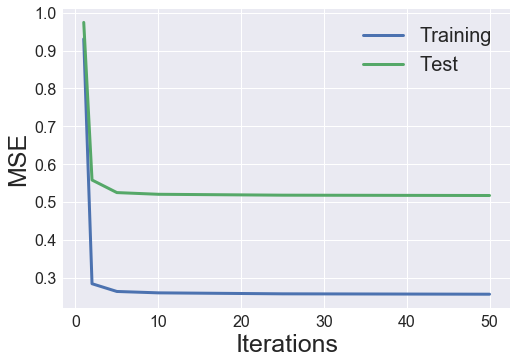

In [22]:
plot_learning_curve(iter_array, mf)